# Fetch and export SNOTEL sites and daily time series data

In [2]:
from collections import OrderedDict
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry as sgeom
import ulmo
import json
import requests

In [5]:
#########################################################################
############################ USER INPUTS ################################
#########################################################################

# DOMAIN
# choose the modeling domain
domain = 'BEAU'

# PATHS
dataPath = '/nfs/attic/dfh/2020_NPRB/data/snotel/'+domain+'/'

#path to domains
domains_resp = requests.get("https://raw.githubusercontent.com/NPRB/02_preprocess_python/main/NPRB_domains.json")
domains = domains_resp.json()

# DATES
st_dt = domains[domain]['st']
ed_dt = domains[domain]['ed']
# st_dt = "1988-09-01"
# ed_dt = "2019-08-31"
#########################################################################

In [6]:
# functions to get SNOTEL stations as geodataframe
def sites_asgdf(ulmo_getsites, stn_proj):
    """ Convert ulmo.cuahsi.wof.get_sites response into a point GeoDataframe
    """
    
    # Note: Found one SNOTEL site that was missing the location key
    sites_df = pd.DataFrame.from_records([
        OrderedDict(code=s['code'], 
        longitude=float(s['location']['longitude']), 
        latitude=float(s['location']['latitude']), 
        name=s['name'], 
        elevation_m=s['elevation_m'])
        for _,s in ulmo_getsites.items()
        if 'location' in s
    ])

    sites_gdf = gpd.GeoDataFrame(
        sites_df, 
        geometry=gpd.points_from_xy(sites_df['longitude'], sites_df['latitude']),
        crs=stn_proj
    )
    return sites_gdf

def get_snotel_stns(domain):
    
    #path to domains
    domains_resp = requests.get("https://raw.githubusercontent.com/NPRB/02_preprocess_python/main/NPRB_domains.json")
    domains = domains_resp.json()

    #Snotel bounding box
    Bbox = domains[domain]['Bbox']

    # Snotel projection
    stn_proj = domains[domain]['stn_proj']
    # model projection
    mod_proj = domains[domain]['mod_proj']

    # Convert the bounding box dictionary to a shapely Polygon geometry using sgeom.box
    box_sgeom = sgeom.box(Bbox['lonmin'], Bbox['latmin'], Bbox['lonmax'], Bbox['latmax'])
    box_gdf = gpd.GeoDataFrame(geometry=[box_sgeom], crs=stn_proj)
    
    # WaterML/WOF WSDL endpoint url 
    #snotel 
    wsdlurl = "https://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL"

    # get dictionary of snotel sites 
    sites = ulmo.cuahsi.wof.get_sites(wsdlurl,user_cache=True)

    #turn sites to geodataframe 
    snotel_gdf = sites_asgdf(sites,stn_proj)
    
    #clip snotel sites to domain bounding box
    gdf = gpd.sjoin(snotel_gdf, box_gdf, how="inner")
    gdf.drop(columns='index_right', inplace=True)
    gdf.reset_index(drop=True, inplace=True)
    
    #scan (east coast)
    wsdlurl_scan = "https://hydroportal.cuahsi.org/Scan/cuahsi_1_1.asmx?WSDL"
    
    # get dictionary of snotel sites 
    scan_sites = ulmo.cuahsi.wof.get_sites(wsdlurl_scan,user_cache=True)
    
    #turn sites to geodataframe 
    scan_gdf = sites_asgdf(scan_sites,stn_proj)
    
    #clip snotel sites to domain bounding box
    gdf2 = gpd.sjoin(scan_gdf, box_gdf, how="inner")
    gdf2.drop(columns='index_right', inplace=True)
    gdf2.reset_index(drop=True, inplace=True)
    
    # concatenate snotel and scan
    frames = [gdf, gdf2]
    gdfs = pd.concat(frames)

    #add columns with projected coordinates 
    CSO_proj = gdfs.to_crs(mod_proj)
    gdfs['easting'] = CSO_proj.geometry.x
    gdfs['northing'] = CSO_proj.geometry.y
    
    return gdfs

In [7]:
def fetch(sitecode, variablecode, start_date, end_date):
    print(sitecode, variablecode, start_date, end_date)
    values_df = None
    #snotel 
    wsdlurl = "https://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL"
    try:
        #Request data from the server
        site_values = ulmo.cuahsi.wof.get_values(
            wsdlurl, 'SNOTEL:'+sitecode, variablecode, start=start_date, end=end_date
        )
        #Convert to a Pandas DataFrame   
        values_df = pd.DataFrame.from_dict(site_values['values'])
        #Parse the datetime values to Pandas Timestamp objects
        values_df['datetime'] = pd.to_datetime(values_df['datetime'])
        #Set the DataFrame index to the Timestamps
        values_df.set_index('datetime', inplace=True)
        #Convert values to float and replace -9999 nodata values with NaN
        values_df['value'] = pd.to_numeric(values_df['value']).replace(-9999, np.nan)
        #Remove any records flagged with lower quality
        values_df = values_df[values_df['quality_control_level_code'] == '1']
    except:
        print("Unable to fetch %s" % variablecode)
    
    return values_df

In [18]:
# returns daily timeseries
# https://www.wcc.nrcs.usda.gov/web_service/AWDB_Web_Service_Reference.htm#commonlyUsedElementCodes
# 'WTEQ': swe [in]
# 'SNWD': snow depth [in]
# 'PRCP': precipitation increment [in]
# 'PREC': precipitation accumulation [in]
# 'TAVG': average air temp [F]
# 'TMIN': minimum air temp [F]
# 'TMAX': maximum air temp [F]
# 'TOBS': observered air temp [F]
def get_snotel_data(gdf,sd_dt, ed_dt,var,units='metric'):
    '''
    gdf - pandas geodataframe of SNOTEL sites
    st_dt - start date string 'yyyy-mm-dd'
    ed_dt - end date string 'yyyy-mm-dd'
    var - snotel variable of interest 
    units - 'metric' (default) or 'imperial'
    '''
    stn_data = pd.DataFrame(index=pd.date_range(start=st_dt, end=ed_dt))
    

    for sitecode in gdf.code:
        try:
            data = fetch(sitecode,'SNOTEL:'+var+'_D', start_date=st_dt, end_date=ed_dt)
            #check for nan values
#             if len(data.value[np.isnan(data.value)]) > 0:
#                 #check if more than 15% of data is missing
#                 if len(data.value[np.isnan(data.value)])/len(data) > .25:
#                     print('More than 25% of days missing')
#                     gdf.drop(gdf.loc[gdf['code']==sitecode].index, inplace=True)
#                     continue
            stn_data[sitecode] = data.value
        except:
            gdf.drop(gdf.loc[gdf['code']==sitecode].index, inplace=True)     
    
    gdf.reset_index(drop=True, inplace=True)
    if units == 'metric':
        if (var == 'WTEQ') |(var == 'SNWD') |(var == 'PRCP') |(var == 'PREC'):
            #convert SNOTEL units[in] to [m]
            for sitecode in gdf.code:
                stn_data[sitecode] = 0.0254 * stn_data[sitecode]
        elif (var == 'TAVG') |(var == 'TMIN') |(var == 'TMAX') |(var == 'TOBS'):
            #convert SNOTEL units[F] to [C]
            for sitecode in gdf.code:
                stn_data[sitecode] = (stn_data[sitecode] - 32) * 5/9
    return gdf, stn_data

# Execute Functions

In [19]:
#get geodataframe of all SNOTEL sites in the domain
snotel_gdf = get_snotel_stns(domain)

#get SWE timeseries 
domain_gdf, swe = get_snotel_data(snotel_gdf,st_dt,ed_dt,'WTEQ')
#get snow depth timeseries 
domain_gdf, hs = get_snotel_data(snotel_gdf,st_dt,ed_dt,'SNWD')
#get precipitation timeseries 
domain_gdf, pr = get_snotel_data(snotel_gdf,st_dt,ed_dt,'PRCP')
#get av temp timeseries 
domain_gdf, tav = get_snotel_data(snotel_gdf,st_dt, ed_dt,'TAVG')
#get min temp timeseries 
domain_gdf, tmn = get_snotel_data(snotel_gdf,st_dt, ed_dt,'TMIN')
#get max temp timeseries 
domain_gdf, tmx = get_snotel_data(snotel_gdf,st_dt, ed_dt,'TMAX')

957_AK_SNTL SNOTEL:WTEQ_D 1988-10-01 2019-09-30


Unable to fetch SNOTEL:WTEQ_D
958_AK_SNTL SNOTEL:WTEQ_D 1988-10-01 2019-09-30
968_AK_SNTL SNOTEL:WTEQ_D 1988-10-01 2019-09-30


Unable to fetch SNOTEL:WTEQ_D
1175_AK_SNTL SNOTEL:WTEQ_D 1988-10-01 2019-09-30
1177_AK_SNTL SNOTEL:WTEQ_D 1988-10-01 2019-09-30


Unable to fetch SNOTEL:WTEQ_D
1183_AK_SNTL SNOTEL:WTEQ_D 1988-10-01 2019-09-30


Unable to fetch SNOTEL:WTEQ_D
958_AK_SNTL SNOTEL:SNWD_D 1988-10-01 2019-09-30
1175_AK_SNTL SNOTEL:SNWD_D 1988-10-01 2019-09-30
958_AK_SNTL SNOTEL:PRCP_D 1988-10-01 2019-09-30
1175_AK_SNTL SNOTEL:PRCP_D 1988-10-01 2019-09-30
958_AK_SNTL SNOTEL:TAVG_D 1988-10-01 2019-09-30
1175_AK_SNTL SNOTEL:TAVG_D 1988-10-01 2019-09-30
958_AK_SNTL SNOTEL:TMIN_D 1988-10-01 2019-09-30
1175_AK_SNTL SNOTEL:TMIN_D 1988-10-01 2019-09-30
958_AK_SNTL SNOTEL:TMAX_D 1988-10-01 2019-09-30
1175_AK_SNTL SNOTEL:TMAX_D 1988-10-01 2019-09-30


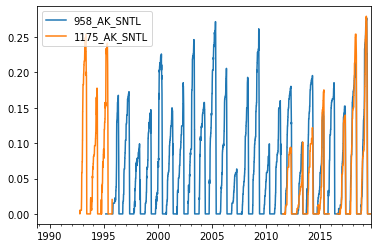

In [24]:
swe.plot()

In [25]:
swe

,958_AK_SNTL,1175_AK_SNTL
1988-10-01,NaN,NaN
1988-10-02,NaN,NaN
1988-10-03,NaN,NaN
1988-10-04,NaN,NaN
1988-10-05,NaN,NaN
...,...,...
2019-09-26,0.0,0.0
2019-09-27,0.0,0.0
2019-09-28,0.0,0.0
2019-09-29,0.0,0.0


# Save Data

In [23]:
# save geojson
out = dataPath + 'Station_'+domain+'.geojson'
domain_gdf.to_file(out, driver='GeoJSON')

#save swe
out = dataPath + 'SNOTEL_data_SWEDmeters'+st_dt+'_'+ed_dt+'.csv'
swe.to_csv(out)

#save hs
out = dataPath + 'SNOTEL_data_HSmeters'+st_dt+'_'+ed_dt+'.csv'
hs.to_csv(out)

#save pr
out = dataPath + 'SNOTEL_data_PRmeters'+st_dt+'_'+ed_dt+'.csv'
pr.to_csv(out)

#save tav
out = dataPath + 'SNOTEL_data_TAVGcelsius'+st_dt+'_'+ed_dt+'.csv'
tav.to_csv(out)

#save tmn
out = dataPath + 'SNOTEL_data_TMINcelsius'+st_dt+'_'+ed_dt+'.csv'
tmn.to_csv(out)

#save tmx
out = dataPath + 'SNOTEL_data_TMAXcelsius'+st_dt+'_'+ed_dt+'.csv'
tmx.to_csv(out)

In [ ]:
# Outfile path
outpath = '/nfs/attic/dfh/2020_NPRB/results/calibration/'+domain+'/prep_files/'

# run all domains

In [10]:
# run all AK domains
domain_list = ['BEAU','BRIS','CHUK','JUNE','KLAW','SITK','TAKU','YUKO']

for domain in domain_list:
    print(domain)
    #where the data should be stored
    dataPath = '/nfs/attic/dfh/2020_NPRB/data/snotel/'+domain+'/'

    #get geodataframe of all SNOTEL sites in the domain
    snotel_gdf = get_snotel_stns(domain)
    
    if len(snotel_gdf) > 0:

        #get SWE timeseries 
        domain_gdf, swe = get_snotel_data(snotel_gdf,st_dt,ed_dt,'WTEQ')
        #get snow depth timeseries 
        domain_gdf, hs = get_snotel_data(snotel_gdf,st_dt,ed_dt,'SNWD')
        #get precipitation timeseries 
        domain_gdf, pr = get_snotel_data(snotel_gdf,st_dt,ed_dt,'PRCP')
        #get av temp timeseries 
        domain_gdf, tav = get_snotel_data(snotel_gdf,st_dt, ed_dt,'TAVG')
        #get min temp timeseries 
        domain_gdf, tmn = get_snotel_data(snotel_gdf,st_dt, ed_dt,'TMIN')
        #get max temp timeseries 
        domain_gdf, tmx = get_snotel_data(snotel_gdf,st_dt, ed_dt,'TMAX')
        
        if len(domain_gdf) > 0:
    
            # save geojson
            out = dataPath + 'Station_'+domain+'.geojson'
            domain_gdf.to_file(out, driver='GeoJSON')

            #save swe
            out = dataPath + 'Station_data_SWEDmeters'+st_dt+'_'+ed_dt+'.csv'
            swe.to_csv(out)

            #save hs
            out = dataPath + 'Station_data_HSmeters'+st_dt+'_'+ed_dt+'.csv'
            hs.to_csv(out)

            #save pr
            out = dataPath + 'Station_data_PRmeters'+st_dt+'_'+ed_dt+'.csv'
            pr.to_csv(out)

            #save tav
            out = dataPath + 'Station_data_TAVGcelsius'+st_dt+'_'+ed_dt+'.csv'
            tav.to_csv(out)

            #save tmn
            out = dataPath + 'Station_data_TMINcelsius'+st_dt+'_'+ed_dt+'.csv'
            tmn.to_csv(out)

            #save tmx
            out = dataPath + 'Station_data_TMAXcelsius'+st_dt+'_'+ed_dt+'.csv'
            tmx.to_csv(out)

BEAU
957_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SNOTEL:WTEQ_D
968_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SNOTEL:WTEQ_D
1175_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
1177_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SNOTEL:WTEQ_D
1183_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SNOTEL:WTEQ_D
1175_AK_SNTL SNOTEL:SNWD_D 1988-09-01 2019-08-31
1175_AK_SNTL SNOTEL:PRCP_D 1988-09-01 2019-08-31
1175_AK_SNTL SNOTEL:TAVG_D 1988-09-01 2019-08-31
1175_AK_SNTL SNOTEL:TMIN_D 1988-09-01 2019-08-31
1175_AK_SNTL SNOTEL:TMAX_D 1988-09-01 2019-08-31
BRIS
1062_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
1086_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SNOTEL:WTEQ_D
1036_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SNOTEL:WTEQ_D
1072_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SNOTEL:WTEQ_D
201_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SNOTEL:WTEQ_D
1003_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
1191_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SNOTEL:WTEQ_D
987_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
973_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SNOTEL:WTEQ_D
1266_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
1232_AK_SCAN SCAN:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SCAN:WTEQ_D
2211_AK_SCAN SCAN:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SCAN:WTEQ_D
2208_AK_SCAN SCAN:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SCAN:WTEQ_D
1233_AK_SCAN SCAN:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SCAN:WTEQ_D
2062_AK_SCAN SCAN:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SCAN:WTEQ_D
2209_AK_SCAN SCAN:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SCAN:WTEQ_D
2063_AK_SCAN SCAN:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SCAN:WTEQ_D
2221_AK_SCAN SCAN:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SCAN:WTEQ_D
1234_AK_SCAN SCAN:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SCAN:WTEQ_D
1266_AK_SNTL SNOTEL:SNWD_D 1988-09-01 2019-08-31
1266_AK_SNTL SNOTEL:PRCP_D 1988-09-01 2019-08-31
1266_AK_SNTL SNOTEL:TAVG_D 1988-09-01 2019-08-31
1266_AK_SNTL SNOTEL:TMIN_D 1988-09-01 2019-08-31
1266_AK_SNTL SNOTEL:TMAX_D 1988-09-01 2019-08-31
CHUK
1036_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SNOTEL:WTEQ_D
1175_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
986_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SNOTEL:WTEQ_D
973_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SNOTEL:WTEQ_D
2213_AK_SCAN SCAN:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SCAN:WTEQ_D
2211_AK_SCAN SCAN:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SCAN:WTEQ_D
2221_AK_SCAN SCAN:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SCAN:WTEQ_D
JUNE
1001_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
1001_AK_SNTL SNOTEL:SNWD_D 1988-09-01 2019-08-31
1001_AK_SNTL SNOTEL:PRCP_D 1988-09-01 2019-08-31
1001_AK_SNTL SNOTEL:TAVG_D 1988-09-01 2019-08-31
1001_AK_SNTL SNOTEL:TMIN_D 1988-09-01 2019-08-31
1001_AK_SNTL SNOTEL:TMAX_D 1988-09-01 2019-08-31
KLAW
SITK
TAKU
1270_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
1001_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
1270_AK_SNTL SNOTEL:SNWD_D 1988-09-01 2019-08-31
1001_AK_SNTL SNOTEL:SNWD_D 1988-09-01 2019-08-31
1270_AK_SNTL SNOTEL:PRCP_D 1988-09-01 2019-08-31
1001_AK_SNTL SNOTEL:PRCP_D 1988-09-01 2019-08-31
1270_AK_SNTL SNOTEL:TAVG_D 1988-09-01 2019-08-31
1001_AK_SNTL SNOTEL:TAVG_D 1988-09-01 2019-08-31
1270_AK_SNTL SNOTEL:TMIN_D 1988-09-01 2019-08-31
1001_AK_SNTL SNOTEL:TMIN_D 1988-09-01 2019-08-31
1270_AK_SNTL SNOTEL:TMAX_D 1988-09-01 2019-08-31
1001_AK_SNTL SNOTEL:TMAX_D 1988-09-01 2019-08-31
YUKO
1267_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
1189_AK_SNTL SNO

Unable to fetch SNOTEL:WTEQ_D
1086_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SNOTEL:WTEQ_D
1182_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
1093_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
958_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
959_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
960_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SNOTEL:WTEQ_D
1071_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SNOTEL:WTEQ_D
1092_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
1174_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
1268_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
961_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SNOTEL:WTEQ_D
962_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SNOTEL:WTEQ_D
956_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
963_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
964_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
1091_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
946_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
1275_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
1036_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SNOTEL:WTEQ_D
1072_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SNOTEL:WTEQ_D
1175_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
966_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
947_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
1096_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
1094_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
949_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
1035_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
1103_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
1073_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
948_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
950_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
986_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SNOTEL:WTEQ_D
1002_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
1178_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SNOTEL:WTEQ_D
973_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SNOTEL:WTEQ_D
1095_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SNOTEL:WTEQ_D
955_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
967_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
1266_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
951_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
1089_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
954_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
952_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
1090_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SNOTEL:WTEQ_D
1055_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
2213_AK_SCAN SCAN:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SCAN:WTEQ_D
2211_AK_SCAN SCAN:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SCAN:WTEQ_D
2208_AK_SCAN SCAN:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SCAN:WTEQ_D
2212_AK_SCAN SCAN:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SCAN:WTEQ_D
2221_AK_SCAN SCAN:WTEQ_D 1988-09-01 2019-08-31


Unable to fetch SCAN:WTEQ_D
1182_AK_SNTL SNOTEL:SNWD_D 1988-09-01 2019-08-31
1093_AK_SNTL SNOTEL:SNWD_D 1988-09-01 2019-08-31
958_AK_SNTL SNOTEL:SNWD_D 1988-09-01 2019-08-31
959_AK_SNTL SNOTEL:SNWD_D 1988-09-01 2019-08-31
1092_AK_SNTL SNOTEL:SNWD_D 1988-09-01 2019-08-31
1174_AK_SNTL SNOTEL:SNWD_D 1988-09-01 2019-08-31
1268_AK_SNTL SNOTEL:SNWD_D 1988-09-01 2019-08-31
956_AK_SNTL SNOTEL:SNWD_D 1988-09-01 2019-08-31
963_AK_SNTL SNOTEL:SNWD_D 1988-09-01 2019-08-31
964_AK_SNTL SNOTEL:SNWD_D 1988-09-01 2019-08-31
1091_AK_SNTL SNOTEL:SNWD_D 1988-09-01 2019-08-31
946_AK_SNTL SNOTEL:SNWD_D 1988-09-01 2019-08-31
1275_AK_SNTL SNOTEL:SNWD_D 1988-09-01 2019-08-31
1175_AK_SNTL SNOTEL:SNWD_D 1988-09-01 2019-08-31
966_AK_SNTL SNOTEL:SNWD_D 1988-09-01 2019-08-31
947_AK_SNTL SNOTEL:SNWD_D 1988-09-01 2019-08-31
1096_AK_SNTL SNOTEL:SNWD_D 1988-09-01 2019-08-31
1094_AK_SNTL SNOTEL:SNWD_D 1988-09-01 2019-08-31
949_AK_SNTL SNOTEL:SNWD_D 1988-09-01 2019-08-31
1035_AK_SNTL SNOTEL:SNWD_D 1988-09-01 2019-08-31
1

Unable to fetch SNOTEL:SNWD_D
955_AK_SNTL SNOTEL:SNWD_D 1988-09-01 2019-08-31
967_AK_SNTL SNOTEL:SNWD_D 1988-09-01 2019-08-31
1266_AK_SNTL SNOTEL:SNWD_D 1988-09-01 2019-08-31
951_AK_SNTL SNOTEL:SNWD_D 1988-09-01 2019-08-31
1089_AK_SNTL SNOTEL:SNWD_D 1988-09-01 2019-08-31
954_AK_SNTL SNOTEL:SNWD_D 1988-09-01 2019-08-31
952_AK_SNTL SNOTEL:SNWD_D 1988-09-01 2019-08-31
1055_AK_SNTL SNOTEL:SNWD_D 1988-09-01 2019-08-31
1182_AK_SNTL SNOTEL:PRCP_D 1988-09-01 2019-08-31
1093_AK_SNTL SNOTEL:PRCP_D 1988-09-01 2019-08-31
958_AK_SNTL SNOTEL:PRCP_D 1988-09-01 2019-08-31
959_AK_SNTL SNOTEL:PRCP_D 1988-09-01 2019-08-31
1092_AK_SNTL SNOTEL:PRCP_D 1988-09-01 2019-08-31
1174_AK_SNTL SNOTEL:PRCP_D 1988-09-01 2019-08-31
1268_AK_SNTL SNOTEL:PRCP_D 1988-09-01 2019-08-31
956_AK_SNTL SNOTEL:PRCP_D 1988-09-01 2019-08-31
963_AK_SNTL SNOTEL:PRCP_D 1988-09-01 2019-08-31
964_AK_SNTL SNOTEL:PRCP_D 1988-09-01 2019-08-31
1091_AK_SNTL SNOTEL:PRCP_D 1988-09-01 2019-08-31
946_AK_SNTL SNOTEL:PRCP_D 1988-09-01 2019-08-31
1

# old

In [8]:
def fetch_scan(sitecode, variablecode, start_date, end_date):
    print(sitecode, variablecode, start_date, end_date)
    values_df = None
    #scan
    wsdlurl = "https://hydroportal.cuahsi.org/Scan/cuahsi_1_1.asmx?WSDL"
    try:
        #Request data from the server
        site_values = ulmo.cuahsi.wof.get_values(
            wsdlurl, 'SCAN:'+sitecode, variablecode, start=start_date, end=end_date
        )
        #Convert to a Pandas DataFrame   
        values_df = pd.DataFrame.from_dict(site_values['values'])
        #Parse the datetime values to Pandas Timestamp objects
        values_df['datetime'] = pd.to_datetime(values_df['datetime'])
        #Set the DataFrame index to the Timestamps
        values_df.set_index('datetime', inplace=True)
        #Convert values to float and replace -9999 nodata values with NaN
        values_df['value'] = pd.to_numeric(values_df['value']).replace(-9999, np.nan)
        #Remove any records flagged with lower quality
        values_df = values_df[values_df['quality_control_level_code'] == '1']
    except:
        print("Unable to fetch %s" % variablecode)
    
    return values_df

In [9]:
# returns daily timeseries
# https://www.wcc.nrcs.usda.gov/web_service/AWDB_Web_Service_Reference.htm#commonlyUsedElementCodes
# 'WTEQ': swe [in]
# 'SNWD': snow depth [in]
# 'PRCP': precipitation increment [in]
# 'PREC': precipitation accumulation [in]
# 'TAVG': average air temp [F]
# 'TMIN': minimum air temp [F]
# 'TMAX': maximum air temp [F]
# 'TOBS': observered air temp [F]
def get_snotel_data(gdf,sd_dt, ed_dt,var,units='metric'):
    '''
    gdf - pandas geodataframe of SNOTEL sites
    st_dt - start date string 'yyyy-mm-dd'
    ed_dt - end date string 'yyyy-mm-dd'
    var - snotel variable of interest 
    units - 'metric' (default) or 'imperial'
    '''
    stn_data = pd.DataFrame(index=pd.date_range(start=st_dt, end=ed_dt))
    

    for sitecode in gdf.code:
        if sitecode[-4:] == 'SNTL':
            try:
                data = fetch(sitecode,'SNOTEL:'+var+'_D', start_date=st_dt, end_date=ed_dt)
                #check for nan values
    ### uncomment this if you want to drop stations with x % missing data
    #             if len(data.value[np.isnan(data.value)]) > 0:
    #                 #check if more than 10% of data is missing
    #                 if len(data.value[np.isnan(data.value)])/len(data) > .15:
    #                     print('More than 15% of days missing')
    #                     gdf.drop(gdf.loc[gdf['code']==sitecode].index, inplace=True)
    #                     continue
                stn_data[sitecode] = data.value
            except:
                gdf.drop(gdf.loc[gdf['code']==sitecode].index, inplace=True)  
                
        if sitecode[-4:] == 'SCAN':
            try:
                data = fetch_scan(sitecode,'SCAN:'+var+'_D', start_date=st_dt, end_date=ed_dt)
                stn_data[sitecode] = data.value
            except:
                gdf.drop(gdf.loc[gdf['code']==sitecode].index, inplace=True)  
                
    gdf.reset_index(drop=True, inplace=True)
    if units == 'metric':
        if (var == 'WTEQ') |(var == 'SNWD') |(var == 'PRCP') |(var == 'PREC'):
            #convert SNOTEL units[in] to [m]
            for sitecode in gdf.code:
                stn_data[sitecode] = 0.0254 * stn_data[sitecode]
        elif (var == 'TAVG') |(var == 'TMIN') |(var == 'TMAX') |(var == 'TOBS'):
            #convert SNOTEL units[F] to [C]
            for sitecode in gdf.code:
                stn_data[sitecode] = (stn_data[sitecode] - 32) * 5/9
    return gdf, stn_data

In [ ]:
# returns daily timeseries
# https://www.wcc.nrcs.usda.gov/web_service/AWDB_Web_Service_Reference.htm#commonlyUsedElementCodes
# 'WTEQ': swe [in]
# 'SNWD': snow depth [in]
# 'PRCP': precipitation increment [in]
# 'PREC': precipitation accumulation [in]
# 'TAVG': average air temp [F]
# 'TMIN': minimum air temp [F]
# 'TMAX': maximum air temp [F]
# 'TOBS': observered air temp [F]
def get_snotel_data(gdf,sd_dt, ed_dt,var,units='metric'):
    '''
    gdf - pandas geodataframe of SNOTEL sites
    st_dt - start date string 'yyyy-mm-dd'
    ed_dt - end date string 'yyyy-mm-dd'
    var - snotel variable of interest 
    units - 'metric' (default) or 'imperial'
    '''
    stn_data = pd.DataFrame(index=pd.date_range(start=st_dt, end=ed_dt))
    

    for sitecode in gdf.code:
        if sitecode[-4:] == 'SNTL':
            try:
                data = fetch(sitecode,'SNOTEL:'+var+'_D', start_date=st_dt, end_date=ed_dt)
                #check for nan values
    ### uncomment this if you want to drop stations with x % missing data
    #             if len(data.value[np.isnan(data.value)]) > 0:
    #                 #check if more than 10% of data is missing
    #                 if len(data.value[np.isnan(data.value)])/len(data) > .15:
    #                     print('More than 15% of days missing')
    #                     gdf.drop(gdf.loc[gdf['code']==sitecode].index, inplace=True)
    #                     continue
                stn_data[sitecode] = data.value
            except:
                gdf.drop(gdf.loc[gdf['code']==sitecode].index, inplace=True)  
                
        if sitecode[-4:] == 'SCAN':
            try:
                data = fetch_scan(sitecode,'SCAN:'+var+'_D', start_date=st_dt, end_date=ed_dt)
                stn_data[sitecode] = data.value
            except:
                gdf.drop(gdf.loc[gdf['code']==sitecode].index, inplace=True)  
                
    gdf.reset_index(drop=True, inplace=True)
    if units == 'metric':
        if (var == 'WTEQ') |(var == 'SNWD') |(var == 'PRCP') |(var == 'PREC'):
            #convert SNOTEL units[in] to [m]
            for sitecode in gdf.code:
                stn_data[sitecode] = 0.0254 * stn_data[sitecode]
        elif (var == 'TAVG') |(var == 'TMIN') |(var == 'TMAX') |(var == 'TOBS'):
            #convert SNOTEL units[F] to [C]
            for sitecode in gdf.code:
                stn_data[sitecode] = (stn_data[sitecode] - 32) * 5/9
    return gdf, stn_data

chena
9
0     960_AK_SNTL
1    1174_AK_SNTL
2     947_AK_SNTL
3     949_AK_SNTL
4     948_AK_SNTL
5     950_AK_SNTL
6     951_AK_SNTL
7     952_AK_SNTL
8    1090_AK_SNTL
Name: code, dtype: object


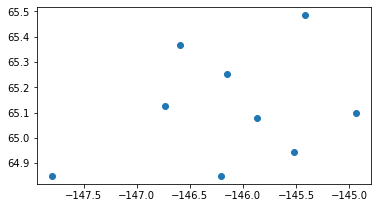

In [23]:
import matplotlib.pyplot as plt
# run all AK domains
domain_list = ['chena']

for domain in domain_list:
    print(domain)
    #get geodataframe of all SNOTEL sites in the domain
    snotel_gdf = get_snotel_stns(domain)
    print(len(snotel_gdf))
    print(snotel_gdf.code)
    if len(snotel_gdf)>0:
        fig, ax = plt.subplots()
        snotel_gdf.plot(ax=ax)

In [7]:
import matplotlib.pyplot as plt
# run all AK domains
domain_list = ['BEAU','BRIS','CHUK','JUNE','KLAW','SITK','TAKU','YUKO']

for domain in domain_list:
    print(domain)
    #get geodataframe of all SNOTEL sites in the domain
    snotel_gdf = get_snotel_stns(domain)
    print(len(snotel_gdf))
    print(snotel_gdf.code)
    if len(snotel_gdf)>0:
        fig, ax = plt.subplots()
        snotel_gdf.plot(ax=ax)

BEAU


KeyboardInterrupt: 

In [8]:
# domain = 'JUNE'
# #get geodataframe of all SNOTEL sites in the domain
# snotel_gdf = get_snotel_stns(domain)
# print(snotel_gdf.code)

# #get xy coordinates of stations in gdf 

# #get SWE timeseries 
# domain_gdf, swe = get_snotel_data(snotel_gdf,st_dt,ed_dt,'WTEQ')

0    1001_AK_SNTL
Name: code, dtype: object
1001_AK_SNTL SNOTEL:WTEQ_D 1988-09-01 2019-08-31
